In [1]:
#导入需要的包
import os
import zipfile
import random
import json
import cv2
import numpy as np
from PIL import Image
import paddle
import paddle.fluid as fluid
from paddle.fluid.dygraph import Linear
import matplotlib.pyplot as plt

In [2]:

'''
参数配置
'''
train_parameters = {
    "input_size": [1, 20, 20],                          #输入图片的shape
    "class_dim": -1,                                    #分类数
    "src_path":"characterData.zip",                     #原始数据集路径
    "target_path":"dataset",                            #要解压的路径
    "train_list_path": "./train_data.txt",              #train_data.txt路径
    "eval_list_path": "./val_data.txt",                 #eval_data.txt路径
    "label_dict":{},                                    #标签字典
    "readme_path": "readme.json",                       #readme.json路径
    "num_epochs": 1,                                    #训练轮数
    "train_batch_size": 32,                             #批次的大小
    "learning_strategy": {                              #优化函数相关的配置
        "lr": 0.001                                     #超参数学习率
    }
}

In [3]:
def unzip_data(src_path,target_path):
    '''
    解压原始数据集，将src_path路径下的zip包解压至data/dataset目录下
    '''
    if(not os.path.isdir(target_path)):
        z = zipfile.ZipFile(src_path, 'r')
        z.extractall(path=target_path)
        z.close()
    else:
        print("文件已解压")

In [4]:

def get_data_list(target_path,train_list_path,eval_list_path):
    '''
    生成数据列表
    '''
    #存放所有类别的信息
    class_detail = []
    #获取所有类别保存的文件夹名称
    data_list_path=target_path
    class_dirs = os.listdir(data_list_path)
    if '__MACOSX' in class_dirs:
        class_dirs.remove('__MACOSX')
    # #总的图像数量
    all_class_images = 0
    # #存放类别标签
    class_label=0
    # #存放类别数目
    class_dim = 0
    # #存储要写进eval.txt和train.txt中的内容
    trainer_list=[]
    eval_list=[]
    #读取每个类别
    for class_dir in class_dirs:
        if class_dir != ".DS_Store":
            class_dim += 1
            #每个类别的信息
            class_detail_list = {}
            eval_sum = 0
            trainer_sum = 0
            #统计每个类别有多少张图片
            class_sum = 0
            #获取类别路径
            path = os.path.join(data_list_path,class_dir)
            # print(path)
            # 获取所有图片
            img_paths = os.listdir(path)
            for img_path in img_paths:                                  # 遍历文件夹下的每个图片
                if img_path =='.DS_Store':
                    continue
                name_path = os.path.join(path,img_path)                       # 每张图片的路径
                if class_sum % 10 == 0:                                 # 每10张图片取一个做验证数据
                    eval_sum += 1                                       # eval_sum为测试数据的数目
                    eval_list.append(name_path + "\t%d" % class_label + "\n")
                else:
                    trainer_sum += 1
                    trainer_list.append(name_path + "\t%d" % class_label + "\n")#trainer_sum测试数据的数目
                class_sum += 1                                          #每类图片的数目
                all_class_images += 1                                   #所有类图片的数目

            # 说明的json文件的class_detail数据
            class_detail_list['class_name'] = class_dir             #类别名称
            class_detail_list['class_label'] = class_label          #类别标签
            class_detail_list['class_eval_images'] = eval_sum       #该类数据的测试集数目
            class_detail_list['class_trainer_images'] = trainer_sum #该类数据的训练集数目
            class_detail.append(class_detail_list)
            #初始化标签列表
            train_parameters['label_dict'][str(class_label)] = class_dir
            class_label += 1

    #初始化分类数
    train_parameters['class_dim'] = class_dim
    print(train_parameters)
    #乱序
    random.shuffle(eval_list)
    with open(eval_list_path, 'a',encoding='utf-8') as f:
        for eval_image in eval_list:
            f.write(eval_image)
    #乱序
    random.shuffle(trainer_list)
    with open(train_list_path, 'a',encoding='utf-8') as f2:
        for train_image in trainer_list:
            f2.write(train_image)

    # 说明的json文件信息
    readjson = {}
    readjson['all_class_name'] = data_list_path                  #文件父目录
    readjson['all_class_images'] = all_class_images
    readjson['class_detail'] = class_detail
    jsons = json.dumps(readjson, sort_keys=True, indent=4, separators=(',', ': '))
    with open(train_parameters['readme_path'],'w',encoding='utf-8') as f:
        f.write(jsons)
    print ('生成数据列表完成！')

In [5]:
def data_reader(file_list):
    '''
    自定义data_reader
    '''
    def reader():
        with open(file_list, 'r',encoding='utf-8') as f:
            lines = [line.strip() for line in f]
            for line in lines:
                img_path, lab = line.strip().split('\t')
                print(img_path)
                img = cv2.imread(img_path)
                print(img.shape)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = np.array(img).astype('float32')
                img = img/255.0
                yield img, int(lab)
    return reader

In [6]:
'''
参数初始化
'''
src_path=train_parameters['src_path']
target_path=train_parameters['target_path']
train_list_path=train_parameters['train_list_path']
eval_list_path=train_parameters['eval_list_path']
batch_size=train_parameters['train_batch_size']
'''
解压原始数据到指定路径
'''
unzip_data(src_path,target_path)

#每次生成数据列表前，首先清空train.txt和eval.txt
with open(train_list_path, 'w',encoding='utf-8') as f:
    f.seek(0)
    f.truncate()
with open(eval_list_path, 'w',encoding='utf-8') as f:
    f.seek(0)
    f.truncate()

#生成数据列表
get_data_list(target_path,train_list_path,eval_list_path)

'''
构造数据提供器
'''
train_reader = paddle.batch(data_reader(train_list_path),
                            batch_size=batch_size,
                            drop_last=True)
eval_reader = paddle.batch(data_reader(eval_list_path),
                            batch_size=batch_size,
                            drop_last=True)


文件已解压
{'input_size': [1, 20, 20], 'class_dim': 65, 'src_path': 'characterData.zip', 'target_path': 'dataset', 'train_list_path': './train_data.txt', 'eval_list_path': './val_data.txt', 'label_dict': {'0': '0', '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': 'A', '11': 'B', '12': 'C', '13': 'cuan', '14': 'D', '15': 'E', '16': 'e1', '17': 'F', '18': 'G', '19': 'gan', '20': 'gan1', '21': 'gui', '22': 'gui1', '23': 'H', '24': 'hei', '25': 'hu', '26': 'J', '27': 'ji', '28': 'jin', '29': 'jing', '30': 'jl', '31': 'K', '32': 'L', '33': 'liao', '34': 'lu', '35': 'M', '36': 'meng', '37': 'min', '38': 'N', '39': 'ning', '40': 'P', '41': 'Q', '42': 'qing', '43': 'qiong', '44': 'R', '45': 'S', '46': 'shan', '47': 'su', '48': 'sx', '49': 'T', '50': 'U', '51': 'V', '52': 'W', '53': 'wan', '54': 'X', '55': 'xiang', '56': 'xin', '57': 'Y', '58': 'yu', '59': 'yu1', '60': 'yue', '61': 'yun', '62': 'Z', '63': 'zang', '64': 'zhe'}, 'readme_path': 'readme.jso

In [7]:
Batch=0
Batchs=[]
all_train_accs=[]
def draw_train_acc(Batchs, train_accs):
    title="training accs"
    plt.title(title, fontsize=24)
    plt.xlabel("batch", fontsize=14)
    plt.ylabel("acc", fontsize=14)
    plt.plot(Batchs, train_accs, color='green', label='training accs')
    plt.legend()
    plt.grid()
    plt.show()

all_train_loss=[]
def draw_train_loss(Batchs, train_loss):
    title="training loss"
    plt.title(title, fontsize=24)
    plt.xlabel("batch", fontsize=14)
    plt.ylabel("loss", fontsize=14)
    plt.plot(Batchs, train_loss, color='red', label='training loss')
    plt.legend()
    plt.grid()
    plt.show()

In [8]:
#定义DNN网络
class MyDNN(fluid.dygraph.Layer):
    def __init__(self):
        super(MyDNN,self).__init__()
        self.hidden1 = Linear(20*20,200,act='relu')
        self.hidden2 = Linear(200,100,act='relu')
        self.hidden3 = Linear(100,100,act='relu')
        self.out = Linear(100,65,act='softmax')
    def forward(self,input):        # forward 定义执行实际运行时网络的执行逻辑
        x = fluid.layers.reshape(input, shape=[-1,20*20]) #-1 表示这个维度的值是从x的元素总数和剩余维度推断出来的，有且只能有一个维度设置为-1
        # print(x.shape)
        x = self.hidden1(x)
        # print('1', x.shape)
        x = self.hidden2(x)
        # print('2',x.shape)
        x = self.hidden3(x)
        # print('3',x.shape)
        y = self.out(x)
        # print('4',y.shape)
        return y

dataset\E\252_E.jpg
(20, 20, 3)
dataset\hu\143_hu.jpg
(20, 20, 3)
dataset\6\625_6.jpg
(20, 20, 3)
dataset\E\18_E.jpg
(20, 20, 3)
dataset\A\175_A.jpg
(20, 20, 3)
dataset\A\640_A.jpg
(20, 20, 3)
dataset\P\147_P.jpg
(20, 20, 3)
dataset\C\88_C.jpg
(20, 20, 3)
dataset\su\35_su.jpg
(20, 20, 3)
dataset\9\50_9.jpg
(20, 20, 3)
dataset\2\577_2.jpg
(20, 20, 3)
dataset\M\240_M.jpg
(20, 20, 3)
dataset\0\84_0.jpg
(20, 20, 3)
dataset\L\228_L.jpg
(20, 20, 3)
dataset\9\514_9.jpg
(20, 20, 3)
dataset\T\97_T.jpg
(20, 20, 3)
dataset\5\739_5.jpg
(20, 20, 3)
dataset\B\120_B.jpg
(20, 20, 3)
dataset\2\30_2.jpg
(20, 20, 3)
dataset\0\414_0.jpg
(20, 20, 3)
dataset\B\260_B.jpg
(20, 20, 3)
dataset\gui\3_gui.jpg
(20, 20, 3)
dataset\Q\108_Q.jpg
(20, 20, 3)
dataset\1\279_1.jpg
(20, 20, 3)
dataset\3\125_3.jpg
(20, 20, 3)
dataset\4\394_4.jpg
(20, 20, 3)
dataset\8\836_8.jpg
(20, 20, 3)
dataset\7\11_7.jpg
(20, 20, 3)
dataset\D\200_D.jpg
(20, 20, 3)
dataset\6\707_6.jpg
(20, 20, 3)
dataset\U\33_U.jpg
(20, 20, 3)
dataset\sha

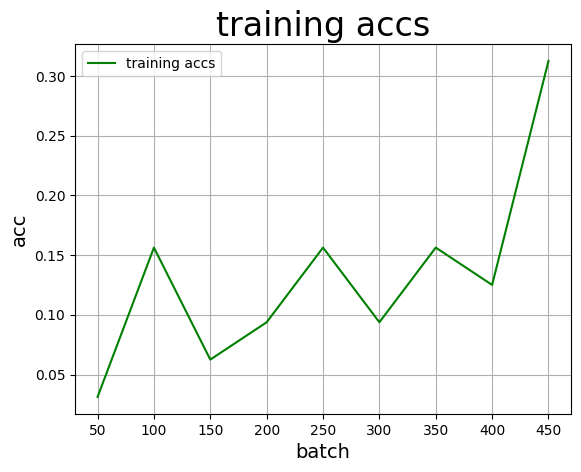

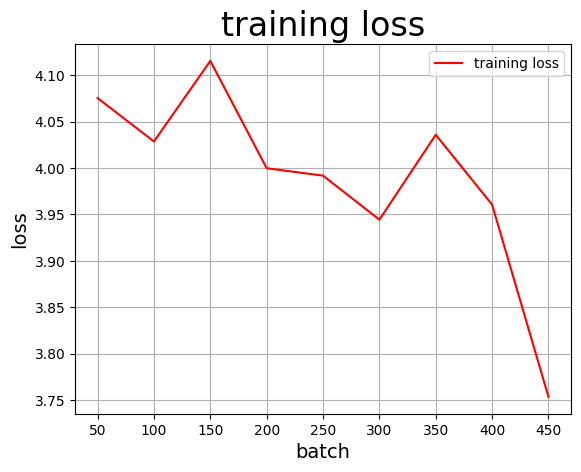

In [9]:
with fluid.dygraph.guard():
    model=MyDNN() #模型实例化
    model.train() #训练模式
    opt=fluid.optimizer.SGDOptimizer(learning_rate=train_parameters['learning_strategy']['lr'], parameter_list=model.parameters())#优化器选用SGD随机梯度下降，学习率为0.001.
    epochs_num=train_parameters['num_epochs'] #迭代次数

    for pass_num in range(epochs_num):
        for batch_id,data in enumerate(train_reader()):
            images=np.array([x[0].reshape(1,20,20) for x in data],np.float32)
            labels = np.array([x[1] for x in data]).astype('int64')
            labels = labels[:, np.newaxis]
            image=fluid.dygraph.to_variable(images)
            label=fluid.dygraph.to_variable(labels)

            predict=model(image) #数据传入model

            loss=fluid.layers.cross_entropy(predict,label)
            avg_loss=fluid.layers.mean(loss)#获取loss值

            acc=fluid.layers.accuracy(predict,label)#计算精度

            if batch_id!=0 and batch_id%50==0:
                Batch = Batch+50
                Batchs.append(Batch)
                all_train_loss.append(avg_loss.numpy()[0])
                all_train_accs.append(acc.numpy()[0])

                print("train_pass:{},batch_id:{},train_loss:{},train_acc:{}".format(pass_num,batch_id,avg_loss.numpy(),acc.numpy()))

            avg_loss.backward()
            opt.minimize(avg_loss)    #优化器对象的minimize方法对参数进行更新
            model.clear_gradients()   #model.clear_gradients()来重置梯度
    fluid.save_dygraph(model.state_dict(),'MyDNN')#保存模型

draw_train_acc(Batchs,all_train_accs)
draw_train_loss(Batchs,all_train_loss)

In [10]:

#模型评估
with fluid.dygraph.guard():
    accs = []
    model_dict, _ = fluid.load_dygraph('MyDNN')
    model = MyDNN()
    model.load_dict(model_dict) #加载模型参数
    model.eval() #训练模式
    for batch_id,data in enumerate(eval_reader()):#测试集
        images=np.array([x[0].reshape(1,20,20) for x in data],np.float32)
        labels = np.array([x[1] for x in data]).astype('int64')
        labels = labels[:, np.newaxis]
        image=fluid.dygraph.to_variable(images)
        label=fluid.dygraph.to_variable(labels)
        predict=model(image)
        acc=fluid.layers.accuracy(predict,label)
        accs.append(acc.numpy()[0])
        avg_acc = np.mean(accs)
    print(avg_acc)

dataset\6\46_6.jpg
(20, 20, 3)
dataset\X\34_X.jpg
(20, 20, 3)
dataset\N\136_N.jpg
(20, 20, 3)
dataset\9\806_9.jpg
(20, 20, 3)
dataset\H\52_H.jpg
(20, 20, 3)
dataset\K\127_K.jpg
(20, 20, 3)
dataset\yu\92_yu.jpg
(20, 20, 3)
dataset\N\52_N.jpg
(20, 20, 3)
dataset\hu\70_hu.jpg
(20, 20, 3)
dataset\min\28_min.jpg
(20, 20, 3)
dataset\sx\19_sx.jpg
(20, 20, 3)
dataset\9\185_9.jpg
(20, 20, 3)
dataset\yu\1_yu.jpg
(20, 20, 3)
dataset\xiang\0_xiang.jpg
(20, 20, 3)
dataset\Y\6_Y.jpg
(20, 20, 3)
dataset\T\118_T.jpg
(20, 20, 3)
dataset\7\235_7.jpg
(20, 20, 3)
dataset\8\783_8.jpg
(20, 20, 3)
dataset\S\145_S.jpg
(20, 20, 3)
dataset\hei\27_hei.jpg
(20, 20, 3)
dataset\J\51_J.jpg
(20, 20, 3)
dataset\L\118_L.jpg
(20, 20, 3)
dataset\E\190_E.jpg
(20, 20, 3)
dataset\yu\65_yu.jpg
(20, 20, 3)
dataset\A\296_A.jpg
(20, 20, 3)
dataset\6\424_6.jpg
(20, 20, 3)
dataset\1\127_1.jpg
(20, 20, 3)
dataset\4\109_4.jpg
(20, 20, 3)
dataset\0\208_0.jpg
(20, 20, 3)
dataset\6\587_6.jpg
(20, 20, 3)
dataset\0\433_0.jpg
(20, 20, 3)

In [13]:
# 对车牌图片进行处理，分割出车牌中的每一个字符并保存
license_plate = cv2.imread('work/license_plate.jpg')
gray_plate = cv2.cvtColor(license_plate, cv2.COLOR_RGB2GRAY)
ret, binary_plate = cv2.threshold(gray_plate, 175, 255, cv2.THRESH_BINARY) #ret：阈值，binary_plate：根据阈值处理后的图像数据
# 按列统计像素分布
result = []
for col in range(binary_plate.shape[1]):
    result.append(0)
    for row in range(binary_plate.shape[0]):
        result[col] = result[col] + binary_plate[row][col]/255
# print(result)
#记录车牌中字符的位置
character_dict = {}
num = 0
i = 0
while i < len(result):
    if result[i] == 0:
        i += 1
    else:
        index = i + 1
        while result[index] != 0:
            index += 1
        character_dict[num] = [i, index-1]
        num += 1
        i = index
# print(character_dict)
#将每个字符填充，并存储
characters = []
for i in range(8):
    if i==2:
        continue
    padding = (170 - (character_dict[i][1] - character_dict[i][0])) / 2
    #将单个字符图像填充为170*170
    ndarray = np.pad(binary_plate[:,character_dict[i][0]:character_dict[i][1]], ((0,0), (int(padding), int(padding))), 'constant', constant_values=(0,0))
    ndarray = cv2.resize(ndarray, (20,20))
    cv2.imwrite('work/' + str(i) + '.png', ndarray)
    characters.append(ndarray)

def load_image(path):
    img = paddle.dataset.image.load_image(file=path, is_color=False)
    img = img.astype('float32')
    img = img[np.newaxis, ] / 255.0
    return img

[[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [138  86  59]
  [133  66  28]
  ...
  [175  68   0]
  [175  72   2]
  [173  76   8]]

 [[  0   0   0]
  [136  84  58]
  [133  66  27]
  ...
  [173  64   0]
  [172  68   2]
  [171  74   7]]

 ...

 [[  0   0   0]
  [182 138 112]
  [175  96  58]
  ...
  [137  58   9]
  [132  65  20]
  [137  82  43]]

 [[  0   0   0]
  [183 139 112]
  [175  96  59]
  ...
  [137  57   9]
  [132  65  20]
  [138  82  44]]

 [[  0   0   0]
  [183 139 113]
  [176  96  59]
  ...
  [137  57   8]
  [131  65  20]
  [138  82  44]]]


In [12]:
#将标签进行转换
print('Label:',train_parameters['label_dict'])
match = {'A':'A','B':'B','C':'C','D':'D','E':'E','F':'F','G':'G','H':'H','I':'I','J':'J','K':'K','L':'L','M':'M','N':'N',
        'O':'O','P':'P','Q':'Q','R':'R','S':'S','T':'T','U':'U','V':'V','W':'W','X':'X','Y':'Y','Z':'Z',
        'yun':'云','cuan':'川','hei':'黑','zhe':'浙','ning':'宁','jin':'津','gan':'赣','hu':'沪','liao':'辽','jl':'吉','qing':'青','zang':'藏',
        'e1':'鄂','meng':'蒙','gan1':'甘','qiong':'琼','shan':'陕','min':'闽','su':'苏','xin':'新','wan':'皖','jing':'京','xiang':'湘','gui':'贵',
        'yu1':'渝','yu':'豫','ji':'冀','yue':'粤','gui1':'桂','sx':'晋','lu':'鲁',
        '0':'0','1':'1','2':'2','3':'3','4':'4','5':'5','6':'6','7':'7','8':'8','9':'9'}
L = 0
LABEL ={}
for V in train_parameters['label_dict'].values():
    LABEL[str(L)] = match[V]
    L += 1
print(LABEL)

Label: {'0': '0', '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': 'A', '11': 'B', '12': 'C', '13': 'cuan', '14': 'D', '15': 'E', '16': 'e1', '17': 'F', '18': 'G', '19': 'gan', '20': 'gan1', '21': 'gui', '22': 'gui1', '23': 'H', '24': 'hei', '25': 'hu', '26': 'J', '27': 'ji', '28': 'jin', '29': 'jing', '30': 'jl', '31': 'K', '32': 'L', '33': 'liao', '34': 'lu', '35': 'M', '36': 'meng', '37': 'min', '38': 'N', '39': 'ning', '40': 'P', '41': 'Q', '42': 'qing', '43': 'qiong', '44': 'R', '45': 'S', '46': 'shan', '47': 'su', '48': 'sx', '49': 'T', '50': 'U', '51': 'V', '52': 'W', '53': 'wan', '54': 'X', '55': 'xiang', '56': 'xin', '57': 'Y', '58': 'yu', '59': 'yu1', '60': 'yue', '61': 'yun', '62': 'Z', '63': 'zang', '64': 'zhe'}
{'0': '0', '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', '10': 'A', '11': 'B', '12': 'C', '13': '川', '14': 'D', '15': 'E', '16': '鄂', '17': 'F', '18': 'G', '19': '赣', '20': '甘

[9, 10, 11, 10, 11, 5, 5]


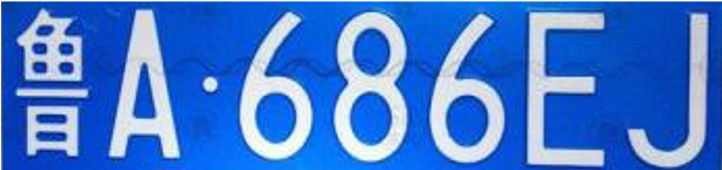

9ABAB55

In [14]:
#构建预测动态图过程
with fluid.dygraph.guard():
    model=MyDNN()#模型实例化
    model_dict,_=fluid.load_dygraph('MyDNN')
    model.load_dict(model_dict)#加载模型参数
    model.eval()#评估模式
    lab=[]
    for i in range(8):
        if i==2:
            continue
        infer_imgs = []
        infer_imgs.append(load_image('work/' + str(i) + '.png'))
        infer_imgs = np.array(infer_imgs)
        infer_imgs = fluid.dygraph.to_variable(infer_imgs)
        result=model(infer_imgs)
        lab.append(np.argmax(result.numpy()))
print(lab)
display(Image.open('work/license_plate.jpg'))
for i in range(len(lab)):
    print(LABEL[str(lab[i])],end='')